# **Skin Cancer Classifier using Transfer Learning**

## **Setup**

**Install Required Libraries**

In [ ]:
!pip install opendatasets torch torchvision scikit-learn seaborn tqdm pillow matplotlib torchsummary torchinfo

**Download Dataset**

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rm1000/skin-cancer-isic-images")

Skipping, found downloaded files in ".\skin-cancer-isic-images" (use force=True to force download)


**Required Imports**

In [ ]:
#import libraries
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler,ConcatDataset
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter
from PIL import Image
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
from torchsummary import summary
#from torchinfo import summary

**Dataset Loading**

In [ ]:
# Fix the Dataset path
base_dir = r'C:\Users\user\Desktop\skin_cancer_efficientNet\skin_cancer_data'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])

# Load the dataset
dataset = ImageFolder(base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print dataset info
print("Number of classes:", len(dataset.classes))
print("Class names:", dataset.classes)



Number of classes: 2
Class names: ['benign', 'malignant']


## **Analysis**

**Dataset Visualization and Analysis**

In [ ]:
"""Retrieve class names, number of classes, and initialize class counts."""
def get_class_info(dataset):

    class_names = dataset.classes
    num_classes = len(class_names)
    class_counts = [0] * num_classes
    return class_names, num_classes, class_counts

In [ ]:
"""Count the number of images in each class."""
def count_images_per_class(dataset):

    _, _, class_counts = get_class_info(dataset)
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts


In [ ]:
"""Visualize a fixed number of images per class."""
def visualize_dataset(dataset, num_images=9):

    class_names, num_classes, _ = get_class_info(dataset)
    class_images = {class_name: [] for class_name in class_names}
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Collect images for each class
    for image, label in dataloader:
        class_name = class_names[label.item()]
        if len(class_images[class_name]) < num_images:
            class_images[class_name].append(image.squeeze(0).permute(1, 2, 0).numpy())

    # Plot images for each class
    plt.figure(figsize=(15, 4 * num_classes))
    for idx, class_name in enumerate(class_names):
        for i, image in enumerate(class_images[class_name]):
            plt.subplot(num_classes, num_images, idx * num_images + i + 1)
            plt.imshow(image)
            if i == 0:
                plt.title(class_name, fontsize=10, pad=10)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
"""Analyze and visualize the distribution of images across classes."""
def analyze_class_distribution(dataset):

    class_names, _, _ = get_class_info(dataset)
    class_counts = count_images_per_class(dataset)

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.title('Distribution of Images Across Classes')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print class distribution
    total_images = sum(class_counts)
    print("\nClass Distribution:")
    print("-" * 50)
    for class_name, count in zip(class_names, class_counts):
        percentage = (count / total_images) * 100
        print(f"{class_name}: {count} images ({percentage:.2f}%)")


In [ ]:
"""Print general statistics about the dataset."""
def print_dataset_stats(dataset):

    class_names, num_classes, _ = get_class_info(dataset)
    total_images = len(dataset)
    image_shape = dataset[0][0].shape
    data_type = dataset[0][0].dtype

    print("\nDataset Statistics:")
    print("-" * 50)
    print(f"Number of classes: {num_classes}")
    print(f"Class names: {class_names}")
    print(f"Total images: {total_images}")
    print(f"Image shape: {image_shape}")
    print(f"Data type: {data_type}")

In [ ]:
"""Run all dataset analyses."""
def run_dataset_analysis(dataset):

    print("Running dataset analysis...")
    print_dataset_stats(dataset)
    visualize_dataset(dataset)
    analyze_class_distribution(dataset)

Running dataset analysis...

Dataset Statistics:
--------------------------------------------------
Number of classes: 2
Class names: ['benign', 'malignant']
Total images: 3297
Image shape: torch.Size([3, 224, 224])
Data type: torch.float32


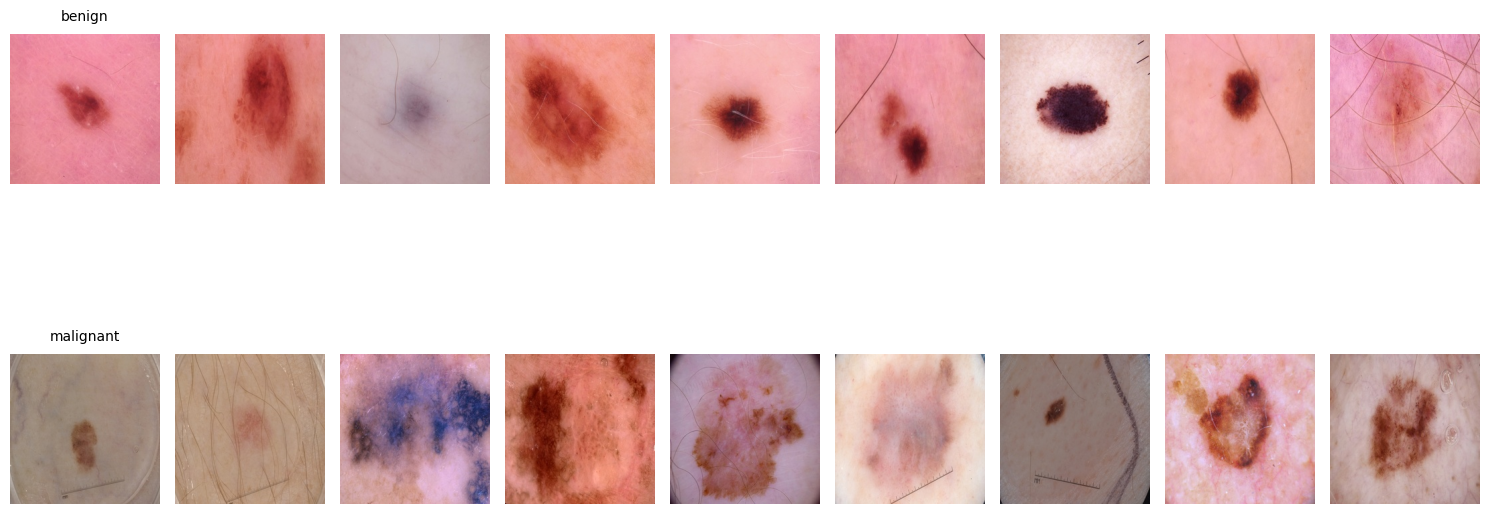

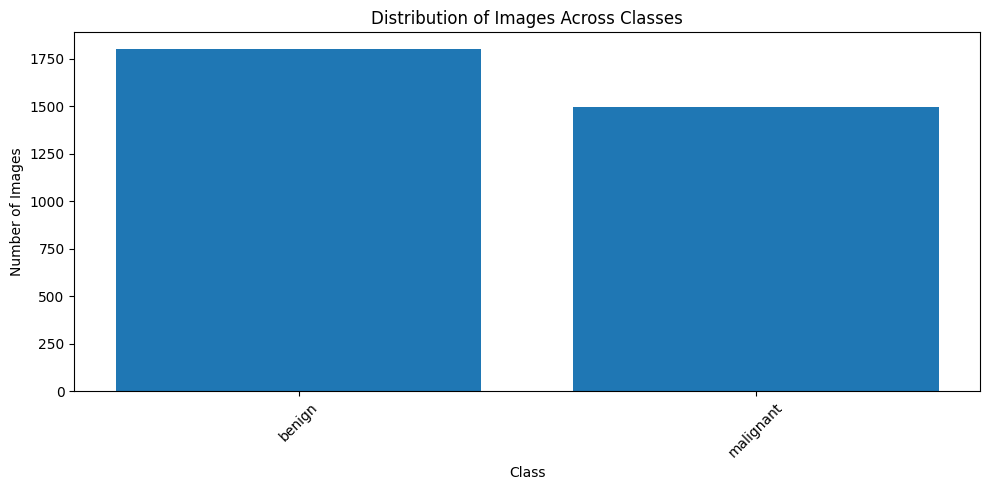


Class Distribution:
--------------------------------------------------
benign: 1800 images (54.60%)
malignant: 1497 images (45.40%)


In [ ]:
# Run all analyses
run_dataset_analysis(dataset)

## **Augmentation**

In [ ]:
# Augmentation Transforms
img_size = (224, 224)
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(),
        transforms.ToTensor(),

])

**Augmented Images Generation**

In [ ]:
# Create a list to hold augmented images
augmented_images = []

# Generate augmented images
for img, label in dataset:
  # Convert the tensor back to a PIL Image
    img_pil = transforms.ToPILImage()(img)
   # Apply the augmentation transformation
    augmented_img = augmentation_transform(img_pil)

    # Store the augmented image and its label
    augmented_images.append((augmented_img, label))

# Create a dataset from the augmented images
augmented_dataset = [(aug_img, label) for aug_img, label in augmented_images]

# Combine original and augmented datasets
combined_dataset = ConcatDataset([dataset, augmented_dataset])

# Create a DataLoader
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)


**Augmented Images Visualization**

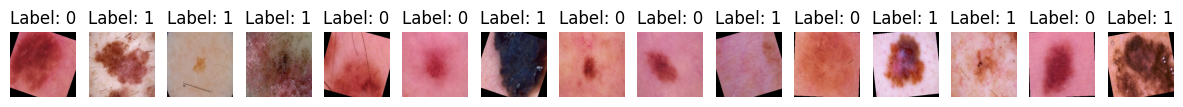

In [ ]:
# Function to convert a tensor to a NumPy array
def tensor_to_numpy(img_tensor):
    # Denormalize if required, then convert to numpy
    img = img_tensor.permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)

# Get a batch of images from the dataloader
data_iter = iter(combined_dataloader)
images, labels = next(data_iter)

# Plot a few images from the batch
num_images = 15  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(15, 6))

for i in range(num_images):
    img = tensor_to_numpy(images[i])
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')

plt.show()

## **Dataset Balancing**

**Check Class Distribution**

Class Distribution in Original Dataset:
Counter({0: 1800, 1: 1497})
Class Distribution in Augmented Dataset:
Counter({0: 1800, 1: 1497})
Class Distribution in Combined Dataset:
{0: 3600, 1: 2994}


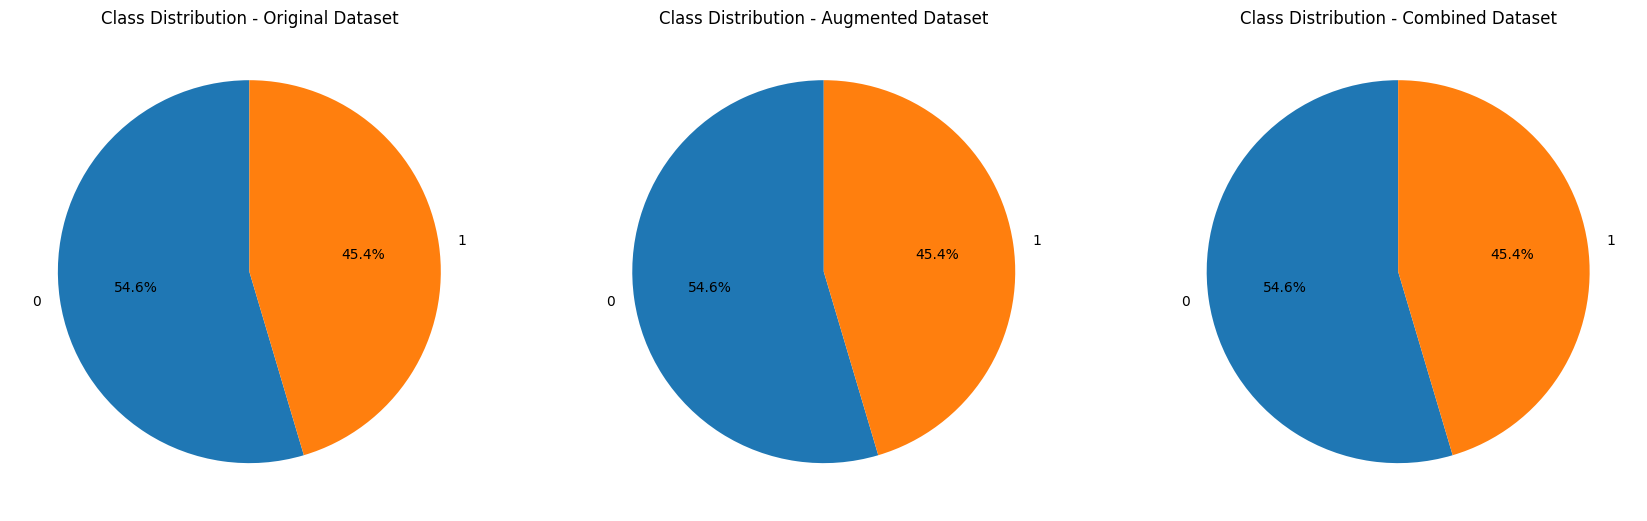

In [ ]:
# Function to compute class distribution
def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

# Get class distributions for both original and augmented datasets
original_class_distribution = get_class_distribution(dataset)
augmented_class_distribution = get_class_distribution(augmented_dataset)

# Combine the class distributions from original and augmented datasets
combined_class_distribution = {key: original_class_distribution.get(key, 0) + augmented_class_distribution.get(key, 0)
                               for key in set(original_class_distribution) | set(augmented_class_distribution)}

# Plot the pie chart for original dataset distribution
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Original dataset distribution pie chart
axes[0].pie(original_class_distribution.values(), labels=original_class_distribution.keys(), autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution - Original Dataset')

# Print the class distributions
print("Class Distribution in Original Dataset:")
print(original_class_distribution)

# Augmented dataset distribution pie chart
axes[1].pie(augmented_class_distribution.values(), labels=augmented_class_distribution.keys(), autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution - Augmented Dataset')

print("Class Distribution in Augmented Dataset:")
print(augmented_class_distribution)

# Combined dataset distribution pie chart
axes[2].pie(combined_class_distribution.values(), labels=combined_class_distribution.keys(), autopct='%1.1f%%', startangle=90)
axes[2].set_title('Class Distribution - Combined Dataset')

print("Class Distribution in Combined Dataset:")
print(combined_class_distribution)
# Display the pie charts
plt.show()

In [ ]:
def get_labels_from_dataset(dataset):
    return [sample[1] for sample in dataset]  # Assuming label is the second element

all_labels = get_labels_from_dataset(combined_dataset)

# Calculate class distribution
class_counts = Counter(all_labels)
num_classes = len(class_counts)
total_samples = len(all_labels)

# Compute class weights
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
weights = [class_weights[label] for label in all_labels]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
# Extract the sampled indices
balanced_indices = list(sampler)

# Create a Subset for the balanced dataset
balanced_dataset = Subset(combined_dataset, balanced_indices)
# Create a DataLoader with the sampler
balanced_dataloader = DataLoader(combined_dataset, batch_size=32, sampler=sampler)

all_labels_balanced = get_labels_from_dataset(balanced_dataset)
# Calculate class distribution
balanced_class_counts = Counter(all_labels_balanced)
num_classes = len(balanced_class_counts)
total_samples = len(all_labels_balanced)

In [ ]:
# Print dataset sizes
print(f"Total original Dataset Size: {len(dataset)}")
print(f"Balanced Dataset Size: {len(balanced_dataset)}")
print("Class Sizes in Balanced Dataset:")
for cls, count in balanced_class_counts.items():
    print(f"Class {cls}: {count}")

Total original Dataset Size: 3297
Balanced Dataset Size: 6594
Class Sizes in Balanced Dataset:
Class 1: 3327
Class 0: 3267


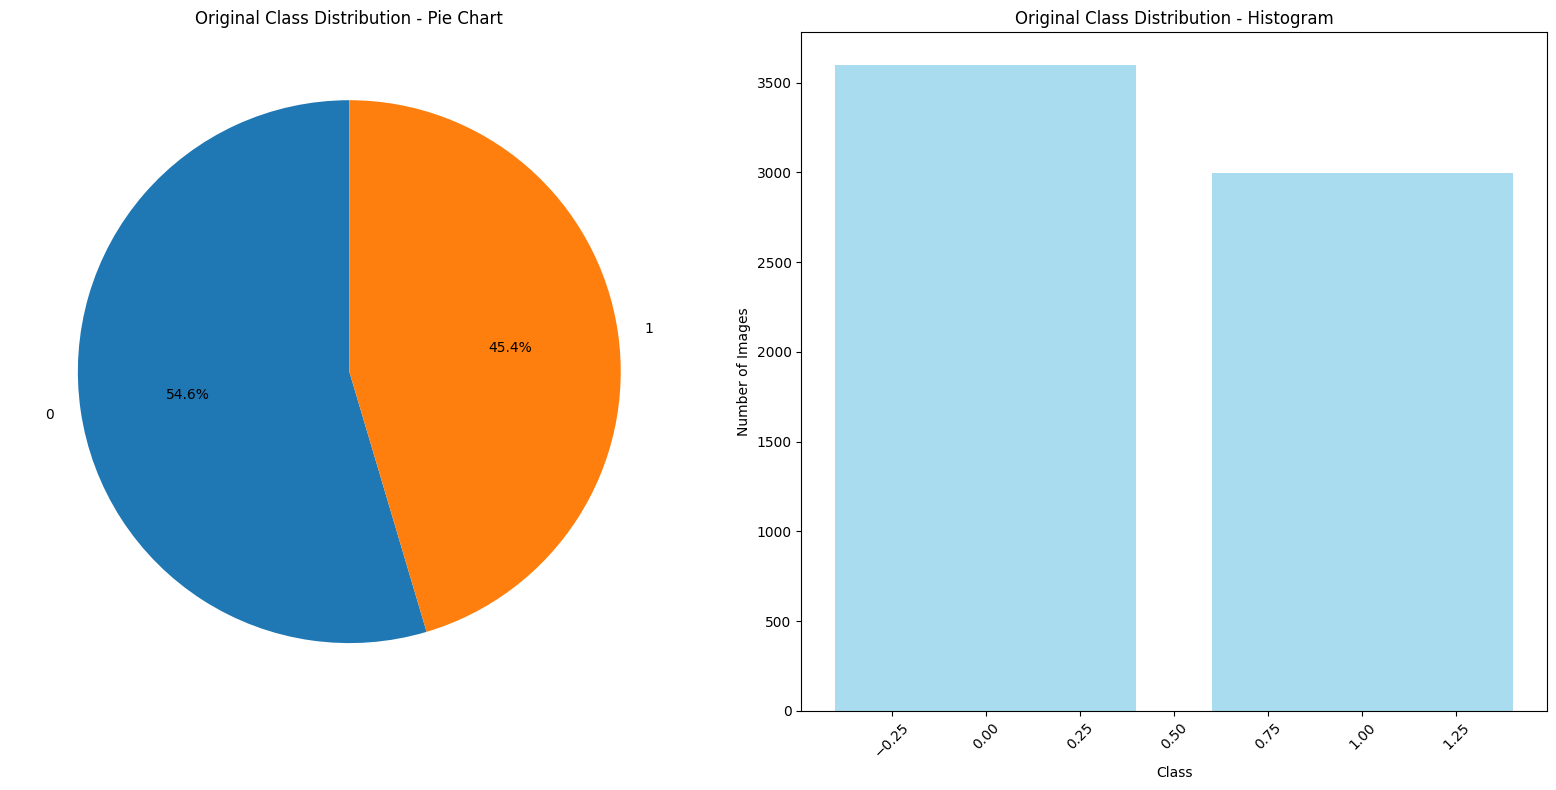

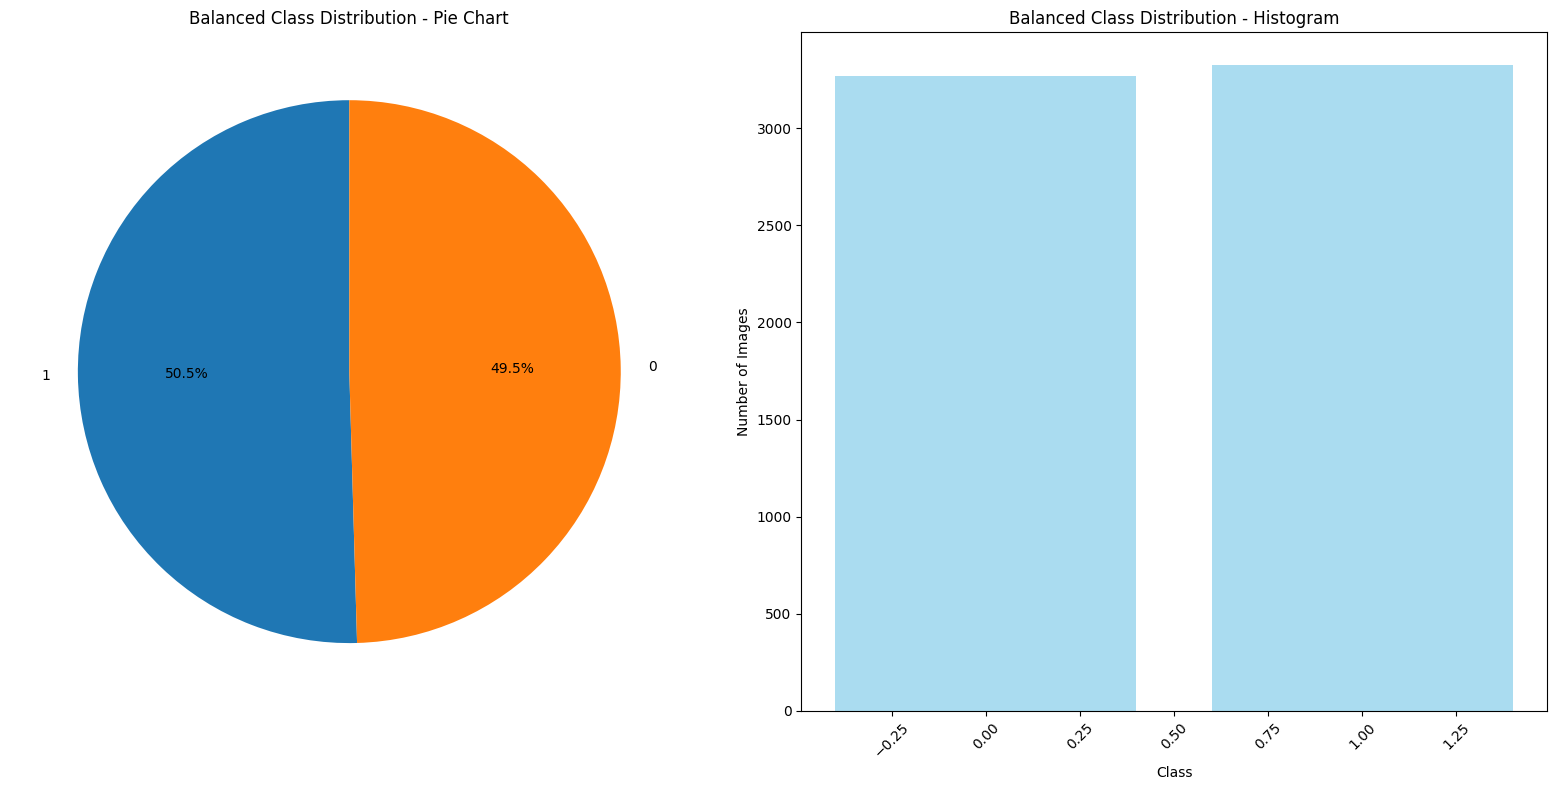

In [ ]:
def plot_class_distribution(class_counts, title):
    labels = list(class_counts.keys())
    sizes = list(class_counts.values())

    # Plot pie chart
    plt.figure(figsize=(16, 8))

    # Subplot 1: Pie Chart
    plt.subplot(1, 2, 1)
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f"{title} - Pie Chart")

    # Subplot 2: Histogram/Bar Chart
    plt.subplot(1, 2, 2)
    plt.bar(labels, sizes, color='skyblue', alpha=0.7)
    plt.title(f"{title} - Histogram")
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_class_distribution(class_counts, "Original Class Distribution")
plot_class_distribution(balanced_class_counts, "Balanced Class Distribution")

## **Finetuning**

**Set Hyper Parameters**

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 20
learning_rate = 0.0001
num_folds = 5
patience = 5  # Number of epochs to wait for improvement before stopping
dataset_dir = base_dir

**K-Folds Cross-Validation Setup**

In [ ]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

**GPU Setup**

In [ ]:
# Ensure GPU memory management is optimal
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Models**

**EfficientNet B5**

In [ ]:
# Uncomment for training EffcientNet B5

def create_model_eff():
    # Load EfficientNetB5 model with pre-trained weights
    model = EfficientNet.from_pretrained('efficientnet-b5')

    # Freeze all convolutional layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the fully connected layer (classifier) to match your output
    model._fc = nn.Sequential(
        nn.Linear(model._fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1),  # Adjust to your output size (1 for binary classification)
        nn.Sigmoid()  # Sigmoid for binary classification
    )

    return model.to(device)



**ResNet50**

In [ ]:
# Uncomment for training ResNet50

def create_model_res():
    model = resnet50(pretrained=True)
     # Freeze all convolutional layers
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    return model.to(device)


**MobileNet V2**

In [ ]:
# Uncomment for training MobileNetV2

def create_model_mobile():
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(pretrained=True)

    # Freeze feature extractor
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace the classifier
    model.classifier = nn.Sequential(
        nn.Linear(model.last_channel, 128),  # Input size is model.last_channel (1280 for MobileNetV2)
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1),  # Binary classification output
        nn.Sigmoid()       # For binary classification
    )

    return model.to(device)



**VGG 16**

In [ ]:
# Uncomment for training VGG16

def create_model_vgg():
    # Load pre-trained VGG16
    model = models.vgg16(pretrained=True)

    # Freeze feature extractor
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1),
        nn.Sigmoid()  # For binary classification
    )

    return model.to(device)


**Model Summary**

In [ ]:
model_eff = create_model_eff()
summary(model_eff, input_size= (3, 225, 225))

Loaded pretrained weights for efficientnet-b5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 226, 226]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13        

In [ ]:
model_res = create_model_res()
summary(model_res, input_size= (3, 225, 225))

C:\Users\user\anaconda3\envs\skin_cancer_effcientNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 113, 113]           9,408
       BatchNorm2d-2         [-1, 64, 113, 113]             128
              ReLU-3         [-1, 64, 113, 113]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
model_mobile = create_model_mobile()
summary(model_mobile, input_size= (3, 225, 225))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 113, 113]             864
       BatchNorm2d-2         [-1, 32, 113, 113]              64
             ReLU6-3         [-1, 32, 113, 113]               0
            Conv2d-4         [-1, 32, 113, 113]             288
       BatchNorm2d-5         [-1, 32, 113, 113]              64
             ReLU6-6         [-1, 32, 113, 113]               0
            Conv2d-7         [-1, 16, 113, 113]             512
       BatchNorm2d-8         [-1, 16, 113, 113]              32
  InvertedResidual-9         [-1, 16, 113, 113]               0
           Conv2d-10         [-1, 96, 113, 113]           1,536
      BatchNorm2d-11         [-1, 96, 113, 113]             192
            ReLU6-12         [-1, 96, 113, 113]               0
           Conv2d-13           [-1, 96, 57, 57]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
model_vgg = create_model_vgg()
summary(model_vgg, input_size= (3, 225, 225))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 225, 225]           1,792
              ReLU-2         [-1, 64, 225, 225]               0
            Conv2d-3         [-1, 64, 225, 225]          36,928
              ReLU-4         [-1, 64, 225, 225]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## **Training and Evaluation**

In [ ]:
def train_and_evaluate1(train_indices, val_indices, test_indices, fold, model_option):
    print(f"Starting Fold {fold + 1}/{num_folds}")
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Create subsets
    train_subset = Subset(balanced_dataset, train_indices)
    val_subset = Subset(balanced_dataset, val_indices)
    test_subset = Subset(balanced_dataset, test_indices)

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Model, loss, optimizer

    if model_option == "resnet":
      model = create_model_res()
      criterion = nn.BCELoss()
      optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
    elif model_option == "effcientNet":
      model = create_model_eff()
      criterion = nn.BCELoss()
      optimizer = optim.Adam(model._fc.parameters(), lr=learning_rate)
    elif model_option == "mobileNet":
      model = create_model_mobile()
      criterion = nn.BCELoss()
      optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    elif model_option == "vgg":
      model = create_model_vgg()
      criterion = nn.BCELoss()
      optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    else:
        print("Invalid Model")
    print(model_option)

    #optmizer, uncomment if using EffcientNetb5
    #optimizer = optim.Adam(model._fc.parameters(), lr=learning_rate)

    #optmizer, uncomment if Resnet50
    #optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    #optmizer, uncomment if using VGG16 and mobilenetv2
    #optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)



    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):  # Number of epochs
        # Training
        model.train()
        train_loss = 0.0
        train_correct, train_total = 0, 0
        with tqdm(total=len(train_loader), desc=f"Fold {fold + 1} Epoch {epoch + 1} - Training", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                preds = (outputs > 0.5).float()
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)

                pbar.set_postfix(loss=train_loss / len(train_loader), acc=100. * train_correct / train_total)
                pbar.update(1)

        train_accuracy = 100. * train_correct / train_total
        metrics['train_loss'].append(train_loss / len(train_loader))
        metrics['train_acc'].append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = 100. * val_correct / val_total
        metrics['val_loss'].append(val_loss / len(val_loader))
        metrics['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch + 1} - Train Loss: {metrics['train_loss'][-1]:.4f}, Train Acc: {metrics['train_acc'][-1]:.2f}%, Val Loss: {metrics['val_loss'][-1]:.4f}, Val Acc: {metrics['val_acc'][-1]:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold}.pth')
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            print(f"Early Stopping Patience Counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch + 1} for Fold {fold + 1}")
            break

    # Plot accuracy and loss graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold + 1} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['val_acc'], label='Val Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.legend()
    plt.show()

    # Evaluate on test set
    model.eval()
    test_correct, test_total = 0, 0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).float()
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_accuracy = 100. * test_correct / test_total
    print(f"Fold {fold + 1} - Test Accuracy: {test_accuracy:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print(f"Confusion Matrix for Fold {fold + 1}:\n", cm)
    print(f"Classification Report for Fold {fold + 1}:\n", classification_report(test_labels, test_preds))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


**Split dataset into train+val and test**

In [ ]:
train_val_indices, test_indices = train_test_split(list(range(len(balanced_dataset))), test_size=0.2, random_state=42)
print(len(train_val_indices),len(test_indices))

5275 1319


**Cross-Validation**

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_indices)):
    train_and_evaluate1(train_idx, val_idx, test_indices, fold,"vgg") #model_option = "resnet", "effcientNet", "mobileNet","vgg"

Starting Fold 1/5
vgg


Fold 1 Epoch 1 - Training:   2%|▍                            | 2/132 [00:21<23:11, 10.70s/batch, acc=57.8, loss=0.0104]


KeyboardInterrupt: 

## **Ensemble**

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchvision import models
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # Added import for roc_curve and auc
import matplotlib.pyplot as plt

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to create models
def create_model(model_name):
    if model_name == 'resnet':
        model = models.resnet50(weights=None)
        model.fc = torch.nn.Sequential(
            torch.nn.Linear(model.fc.in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )
    elif model_name == 'efficientnetb5':
        model = EfficientNet.from_name('efficientnet-b5')
        model._fc = torch.nn.Sequential(
            torch.nn.Linear(model._fc.in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )
    elif model_name == 'vgg16':
        model = models.vgg16(weights=None)
        model.classifier[6] = torch.nn.Sequential(
            torch.nn.Linear(4096, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )
    elif model_name == 'mobilenet':
        model = models.mobilenet_v2(weights=None)
        model.classifier = torch.nn.Sequential(
            torch.nn.Linear(model.last_channel, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )
    else:
        raise ValueError("Invalid model name.")

    # Move the model to the GPU
    model = model.to(device)
    return model

# Function to load model weights
def load_model_weights(model, model_name):
    checkpoint_path = f'C:/Users/user/Desktop/skin_cancer_efficientNet/models/{model_name}.pth'
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint

    # Remove mismatched keys
    model_state_dict = model.state_dict()
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}
    model_state_dict.update(filtered_state_dict)

    model.load_state_dict(model_state_dict, strict=False)
    model.eval()
    return model

# Split the dataset into train+validation and test sets
train_val_indices, test_indices = train_test_split(list(range(len(balanced_dataset))), test_size=0.2, random_state=42)
print(len(train_val_indices), len(test_indices))

# Create subsets for training/validation and testing
train_val_subset = Subset(balanced_dataset, train_val_indices)
test_subset = Subset(balanced_dataset, test_indices)

# Create DataLoaders for training/validation and testing
train_val_dataloader = DataLoader(train_val_subset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=16, shuffle=False)

# Create models and load weights
models_dict = {
    'resnet': load_model_weights(create_model('resnet'), 'resnet'),
    'efficientnetb5': load_model_weights(create_model('efficientnetb5'), 'efficientnetb5'),
    'vgg16': load_model_weights(create_model('vgg16'), 'vgg16'),
    'mobilenet': load_model_weights(create_model('mobilenet'), 'mobilenet'),
}

# Define a function to get ensemble predictions
def get_ensemble_predictions(models_dict, dataloader):
    all_preds = []
    all_labels = []

    # Turn off gradient calculation to save memory during inference
    with torch.no_grad():
        for imgs, labels in dataloader:
            # Move the data to the GPU
            imgs, labels = imgs.to(device), labels.to(device)

            # Make predictions for each model
            resnet_preds = models_dict['resnet'](imgs)
            efficientnet_preds = models_dict['efficientnetb5'](imgs)
            vgg_preds = models_dict['vgg16'](imgs)
            mobilenet_preds = models_dict['mobilenet'](imgs)

            # Average the predictions for the ensemble
            ensemble_preds = (resnet_preds + efficientnet_preds + vgg_preds + mobilenet_preds) / 4

            all_preds.append(ensemble_preds)
            all_labels.append(labels)

            # Free up memory
            del resnet_preds, efficientnet_preds, vgg_preds, mobilenet_preds
            torch.cuda.empty_cache()  # Clear cache after each batch

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_preds, all_labels

# Get the ensemble predictions on the test dataset
ensemble_preds, ensemble_labels = get_ensemble_predictions(models_dict, test_dataloader)

# Convert predictions to numpy
ensemble_preds_np = ensemble_preds.detach().cpu().numpy()
ensemble_labels_np = ensemble_labels.detach().cpu().numpy()

# Round the predictions for binary classification (0 or 1)
predictions = np.round(ensemble_preds_np)

# 1. Classification Report
print("Classification Report:\n")
print(classification_report(ensemble_labels_np, predictions))

# 2. Confusion Matrix
cm = confusion_matrix(ensemble_labels_np, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# 3. ROC Curve
fpr, tpr, _ = roc_curve(ensemble_labels_np, ensemble_preds_np)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 4. AUC Score
print(f"\nAUC Score: {roc_auc:.2f}")




5275 1319


C:\Users\user\AppData\Local\Temp\ipykernel_5912\3615690182.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

KeyboardInterrupt: 